# TRAINING

## PREPARE DATASET, DEFINE LOSS

In [1]:
# Only for Colab
from google.colab import drive
drive.mount('/content/drive')

# Set the current working directory
import os
os.chdir('/content/drive/MyDrive/ml-verifier-oracle/training')
print("Current path: " + os.getcwd())

Mounted at /content/drive
Current path: /content/drive/MyDrive/ml-verifier-oracle/training


In [2]:
# Import dependencies for training
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

import tqdm

from defineSNN import MODSiameseBambooNN
from defineAdjustedSNN import FurtherAdjustedSiameseBambooNN
from defineReducedSNN import ReducedParamsSiameseBambooNN

In [4]:
# Load and inspect the dataset
# Read the CSV file
df = pd.read_csv('dataset10k20x20/forest_dataset.csv')

# Display the modified DataFrame
print(df)

                 imageT0             imageT1  label
0        forestT0_0.jpeg     forestT1_0.jpeg      0
1        forestT0_1.jpeg     forestT1_1.jpeg      0
2        forestT0_2.jpeg     forestT1_2.jpeg      0
3        forestT0_3.jpeg     forestT1_3.jpeg      0
4        forestT0_4.jpeg     forestT1_4.jpeg      0
...                  ...                 ...    ...
4995  forestT0_4995.jpeg  forestT1_4995.jpeg      1
4996  forestT0_4996.jpeg  forestT1_4996.jpeg      1
4997  forestT0_4997.jpeg  forestT1_4997.jpeg      1
4998  forestT0_4998.jpeg  forestT1_4998.jpeg      1
4999  forestT0_4999.jpeg  forestT1_4999.jpeg      1

[5000 rows x 3 columns]


In [5]:
# Change directory to dataset path
os.chdir('/content/drive/MyDrive/ml-verifier-oracle/training/dataset10k20x20')
print("Current path: " + os.getcwd())

Current path: /content/drive/MyDrive/ml-verifier-oracle/training/dataset10k20x20


In [6]:
# Split the dataset into training and testing sets

image1_paths = df['imageT0'].tolist()
image2_paths = df['imageT1'].tolist()
labels = df['label'].tolist()


train_image1_paths, test_image1_paths, train_image2_paths, test_image2_paths, train_labels, test_labels = train_test_split(
    image1_paths, image2_paths, labels, test_size=0.2, random_state=42
)

In [7]:
# Define loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [8]:
# Prepare the dataset
class ForestDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, labels, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img1 = Image.open(self.image1_paths[idx]).convert('L')
        img2 = Image.open(self.image2_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)


        return img1, img2, label

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((10, 10)),
    transforms.ToTensor(),
])


# Create datasets and dataloaders
train_dataset = ForestDataset(train_image1_paths, train_image2_paths, train_labels, transform=transform)
test_dataset = ForestDataset(test_image1_paths, test_image2_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## TRAIN, EVALUATE AND SAVE MODEL

In [ ]:
# TRAIN THE MODEL
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReducedParamsSiameseBambooNN().to(device)


# Display the network architecture
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

criterion = torch.nn.BCEWithLogitsLoss()


# Training loop
num_epochs = 10
learning_rates = [10, 5, 2, 0.1, 0.01]
avg_losses = {lr: [] for lr in learning_rates}
accuracies = {lr: [] for lr in learning_rates}

for lr in learning_rates:

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):

        total_loss = 0
        total_batches = 0
        model.train()

        for batch in train_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            finalout = model(img1, img2)
            output1 = model.forward_one(img1)
            output2 = model.forward_one(img2)

            labels = torch.zeros_like(finalout)
            labels[label.view(-1, 1) == 1] = 1
            loss = criterion(finalout, labels.float())


            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_batches += 1

        average_loss = total_loss / total_batches
        avg_losses[lr].append(average_loss)
        print(f'Learning Rate: {lr}, Avg loss: {average_loss}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for batch in test_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            finalout = model(img1, img2)
            predicted_labels = (torch.sigmoid(finalout) > 0.5).float()

            total += label.size(0)
            correct += (predicted_labels.view(-1) == label).sum().item()

        accuracy = correct / total
        accuracies[lr].append(accuracy)
        print(f'Learning Rate: {lr}, Test Accuracy: {accuracy * 100:.2f}%')


    # Save just params
    torch.save(model.state_dict(), f'trained_simplesnn_lr_{lr}S.pth')


Total number of parameters: 8545
Learning Rate: 10, Avg loss: 0.6417980516701937
Learning Rate: 10, Avg loss: 0.4742588309943676
Learning Rate: 10, Avg loss: 0.2860115852020681
Learning Rate: 10, Avg loss: 0.2104360856488347
Learning Rate: 10, Avg loss: 0.16929841448087246
Learning Rate: 10, Avg loss: 0.14778095144662073
Learning Rate: 10, Avg loss: 0.1246364062448265
Learning Rate: 10, Avg loss: 0.12099032906466163
Learning Rate: 10, Avg loss: 0.10501971971360036
Learning Rate: 10, Avg loss: 0.0992737009935081
Learning Rate: 10, Test Accuracy: 92.20%
Learning Rate: 5, Avg loss: 0.08469076229463099
Learning Rate: 5, Avg loss: 0.08742723233823199
Learning Rate: 5, Avg loss: 0.08124944703362416
Learning Rate: 5, Avg loss: 0.0750354614029493
Learning Rate: 5, Avg loss: 0.07474106158813243
Learning Rate: 5, Avg loss: 0.07377086790773318
Learning Rate: 5, Avg loss: 0.06990665255536442
Learning Rate: 5, Avg loss: 0.06628771503550525
Learning Rate: 5, Avg loss: 0.06511025123701984
Learning Ra

## PLOT

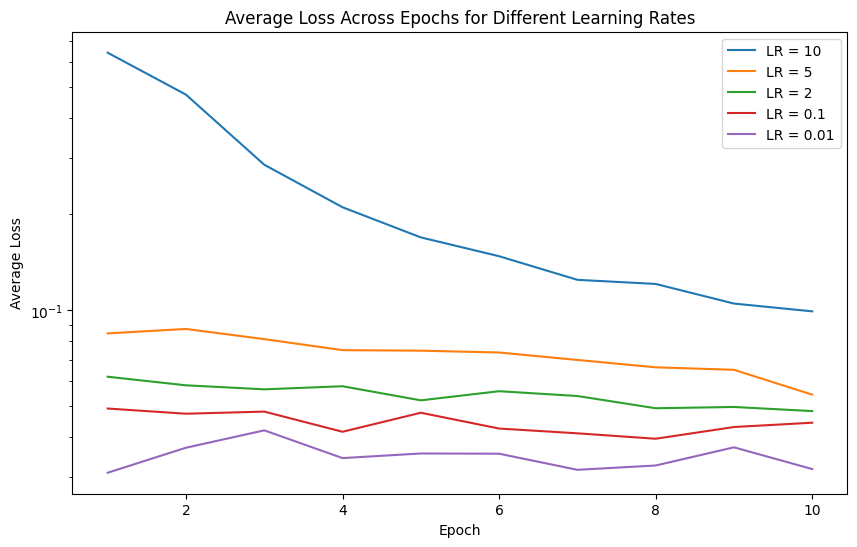

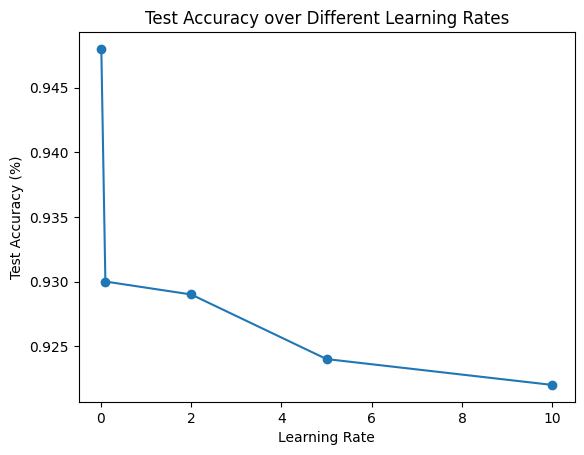

In [ ]:
# Plotting the average loss for each learning rate
plt.figure(figsize=(10, 6))
for lr, losses in avg_losses.items():
    plt.plot(range(1, num_epochs + 1), losses, label=f'LR = {lr}')

plt.title('Average Loss Across Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

# Plotting accuracies over learning rates
lr_values = [lr for lr in learning_rates]
accuracy_values = [accuracies[lr][-1] for lr in learning_rates]
plt.plot(lr_values, accuracy_values, marker='o', linestyle='-')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Different Learning Rates')
plt.show()